# Usuwanie wiszących kabli ze zdjęć krajobrazu górskiego
**Autorzy:** Mikołaj Nowak (151813), Anna Roszkiewicz (151883)

## Cel projektu

Celem projektu jest zastosowanie operacji jednopunktowych, splotowych, morfologicznych oraz spektralnych do usunięcia obiektów przesłaniających pożądane elementy obrazu, czyli krajobrazu górskiego, przy jednoczesnym zachowaniu wysokiej ostrości obrazu.

W projekcie wykorzystano następujący zestaw danych:
- **Wire Removal** – zbiór zdjęć przedstawiających krajobraz górski przesłonięty kablami linii wysokiego napięcia. Zdjęcia zostały wykonane z nieco różnych perspektyw.  
Dane są dostępne pod tym [linkiem](http://grail.cs.washington.edu/projects/photomontage/).


## Import bibliotek

W pierwszej kolejności zaimportowano niezbędne biblioteki, które umożliwiają przetwarzanie obrazów, tworzenie wizualizacji oraz obsługę danych.

In [ ]:
# import niezbędnych bibliotek
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
%matplotlib inline
from pandas import DataFrame
import pandas as pd
from IPython.display import display, HTML
from skimage.exposure import rescale_intensity
import plotly.graph_objects as go
import pandas as pd

pd.options.display.html.border = 0
pd.options.display.float_format = '{:,.2f}'.format

## Pobranie i rozpakowanie danych

W celu przeprowadzenia eksperymentu pobrano zestaw zdjęć krajobrazu górskiego przesłoniętego kablami.  
Dane zostały pobrane bezpośrednio ze strony projektu i automatycznie rozpakowane do katalogu roboczego.

In [ ]:
# pobranie niezbędnych zasobów
!wget -O wire.zip http://grail.cs.washington.edu/projects/photomontage/data/wire.zip && unzip -o wire.zip

--2025-04-23 21:11:45--  http://grail.cs.washington.edu/projects/photomontage/data/wire.zip
Resolving grail.cs.washington.edu (grail.cs.washington.edu)... 128.208.5.93, 2607:4000:200:14::5d
Connecting to grail.cs.washington.edu (grail.cs.washington.edu)|128.208.5.93|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://grail.cs.washington.edu/projects/photomontage/data/wire.zip [following]
--2025-04-23 21:11:45--  https://grail.cs.washington.edu/projects/photomontage/data/wire.zip
Connecting to grail.cs.washington.edu (grail.cs.washington.edu)|128.208.5.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6112825 (5.8M) [application/zip]
Saving to: ‘wire.zip’

wire.zip            100%[===================>]   5.83M   985KB/s    in 5.9s    

2025-04-23 21:11:51 (1008 KB/s) - ‘wire.zip’ saved [6112825/6112825]

Archive:  wire.zip
  inflating: wire/aligned78.png      
  inflating: wire/aligned80.png      
  inflating: wire/aligned81.p

Ze względu na problem z wyświetlaniem obrazów przez bibliotekę OpenCV w środowisku Colab, w przypadku korzystania z tej platformy należy skorzystać z funkcji specjalnie do tego przygotowanej.

In [ ]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

## Wizualizacja danych wejściowych

Załadowano zestaw zdjęć krajobrazu, z których każde zostało wykonane z nieco innej perspektywy oraz z różnym stopniem przesłonięcia przez kable linii trakcyjnej.  
Dzięki niewielkim przesunięciom pomiędzy obrazami możliwe jest późniejsze wykorzystanie różnic lokalnych do rekonstrukcji niezasłoniętego krajobrazu.


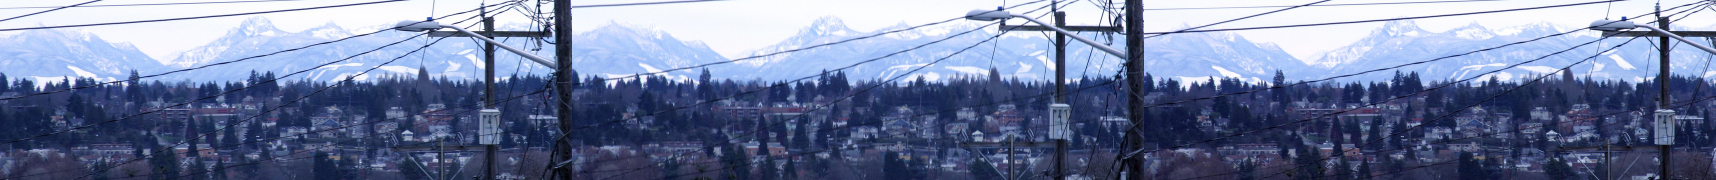

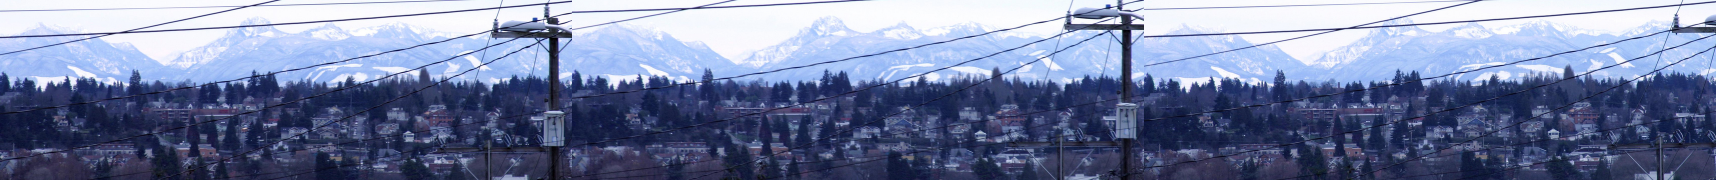

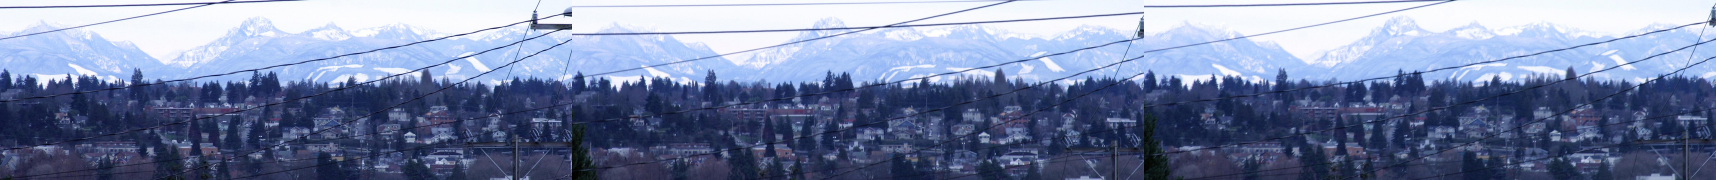

In [ ]:
files = [
    './wire/aligned78.png',
    './wire/aligned80.png',
    './wire/aligned81.png',
    './wire/aligned83.png',
    './wire/aligned84.png',
    './wire/aligned85.png',
    './wire/aligned86.png',
    './wire/aligned87.png',
    './wire/aligned88.png',
]

wires = [cv2.imread(f, 1) for f in files]
wires = list(map(lambda i: cv2.resize(i, None, fx=0.5, fy=0.5), wires))

imshow(np.concatenate(wires[0:3], 1))
imshow(np.concatenate(wires[3:6], 1))
imshow(np.concatenate(wires[6:9], 1))

# 1. Konwersja do skali szarości

Na początku każde zdjęcie zostało przekształcone do skali szarości.  
Konwersja kolorowych obrazów do odcieni szarości znacząco upraszcza dalsze przetwarzanie danych, a w szczególności zastosowanie operacji morfologicznych, które będą wykorzystywane w kolejnych etapach algorytmu.

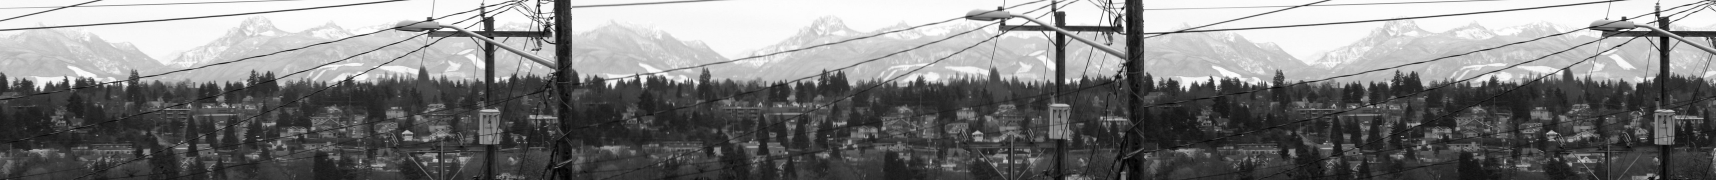

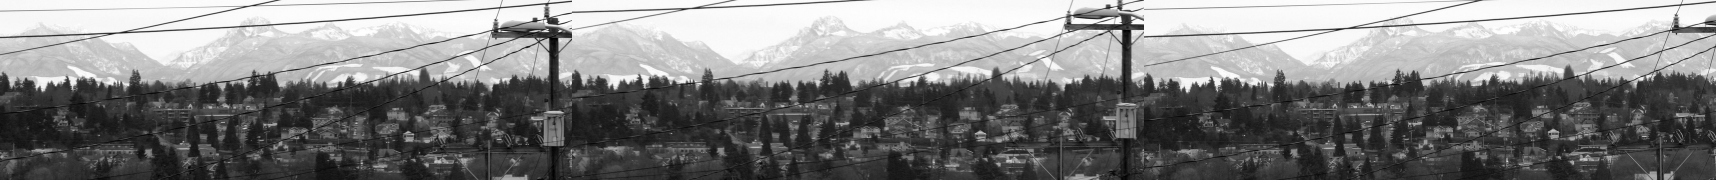

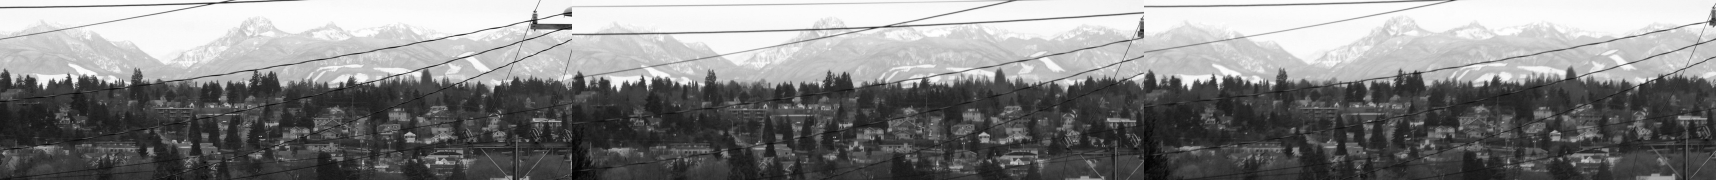

In [ ]:
wires_gray = [cv2.cvtColor(w, cv2.COLOR_BGR2GRAY) for w in wires]

imshow(np.concatenate(wires_gray[0:3], 1))
imshow(np.concatenate(wires_gray[3:6], 1))
imshow(np.concatenate(wires_gray[6:9], 1))

# 2. Wykrywanie intensywnych krawędzi na obrazach

Następnie należy wykryć obszary obrazu charakteryzujące się dużą zmiennością i kontrastem, czyli miejsc, w których prawdopodobnie znajdują się kable.

W tym celu wykorzystano filtr Sobela, a następnie dodatkowe operacje morfologiczne, aby poprawić jakość uzyskanych krawędzi.

## 2.1. Obliczenie mapy intensywności gradientu

Dla każdego obrazu w skali szarości wylicza się mapę intensywności na podstawie pochodnych w kierunku poziomym i pionowym (filtry Sobela).

## 2.2. Progowanie niskich wartości intensywności

Aby usunąć bardzo niewielkie zmienności (szum lub detale tła), zastosowano próg, poniżej którego wartości intensywności są zerowane.

## 2.3. Operacje morfologiczne na obrazie krawędzi

Po progowaniu zastosowano zamknięcie właściwe, czyli serię operacji morfologicznych:

- zamknięcie (`closing`) — aby połączyć ze sobą fragmenty kabli, które mogły zostać przerwane przez filtr Sobela,
- otwarcie (`opening`) — aby usunąć pojedyncze drobne zakłócenia,
- ponowne zamknięcie — dla dalszego uzupełnienia przerw w detekcji kabli.

Dzięki temu otrzymano oczyszczoną mapę potencjalnych lokalizacji kabli gotową do dalszej obróbki.

In [ ]:
def calculate_intensity(img, threshold=0.2, kernel_size=3):
    img = img / 255.0
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    edges = np.sqrt(sobel_x**2 + sobel_y**2)
    edges = rescale_intensity(edges)
    edges[edges < threshold] = 0
    edges_bin = (edges * 255).astype(np.uint8)
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    edges_clean = cv2.morphologyEx(edges_bin, cv2.MORPH_CLOSE, kernel)
    edges_clean = cv2.morphologyEx(edges_clean, cv2.MORPH_OPEN, kernel)
    edges_clean = cv2.morphologyEx(edges_clean, cv2.MORPH_CLOSE, kernel)
    edges_clean = edges_clean.astype(np.float32)
    return edges_clean

Próg został dobrany eksperymentalnie. Wartość `0.2` okazuje się być najlepszym kompromisem pomiędzy eliminacją szumu a zachowaniem właściwych krawędzi odpowiadających kablom.

Dla lepszego zobrazowania działania prógowania, przedstawiono wyniki dla różnych progów w zakresie od `0.0` do `0.4` z krokiem `0.05` na wybranym przykładzie obrazu.

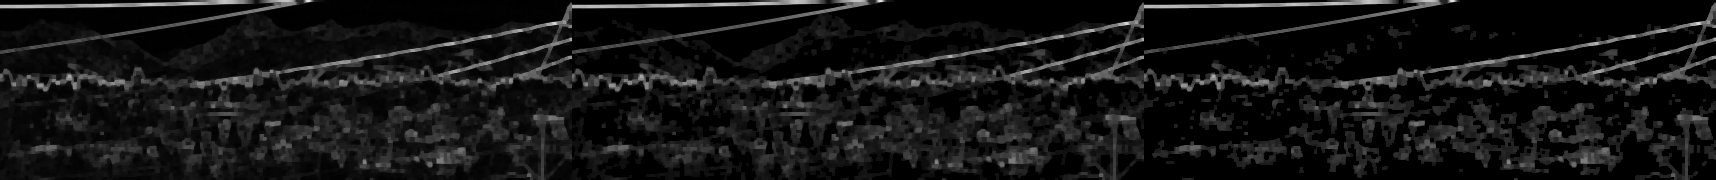

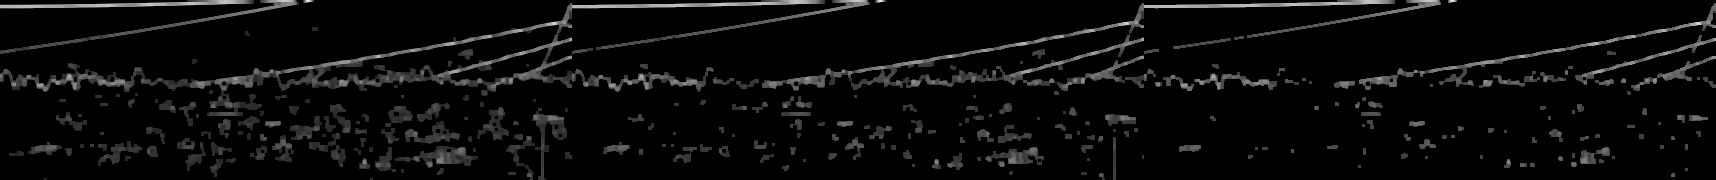

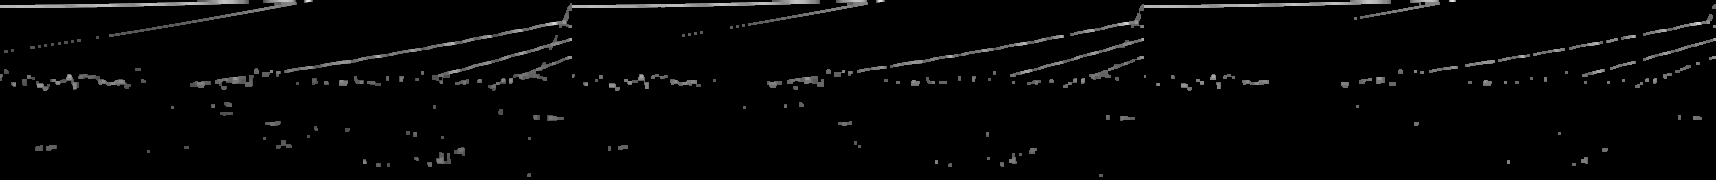

In [ ]:
thresholds = np.arange(0.0, 0.45, 0.05)
images = []

for t in thresholds:
    img = calculate_intensity(wires_gray[-1], threshold=t)
    images.append(img)

imshow(np.concatenate(images[0:3], axis=1))
imshow(np.concatenate(images[3:6], axis=1))
imshow(np.concatenate(images[6:], axis=1))

## Wizualizacja zdjęć po detekcji obszarów o wysokiej zmienności

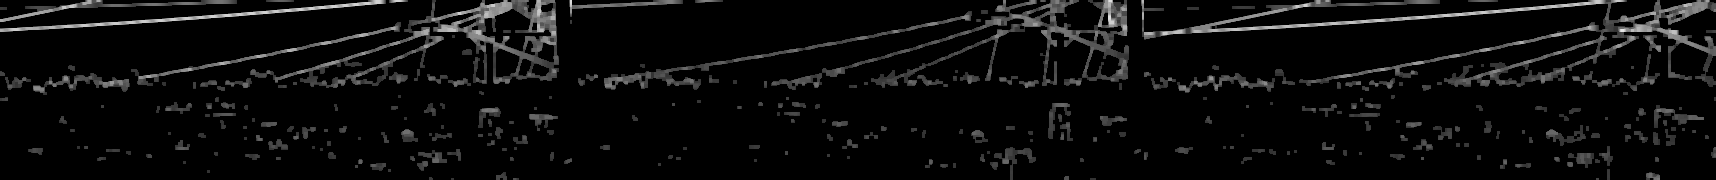

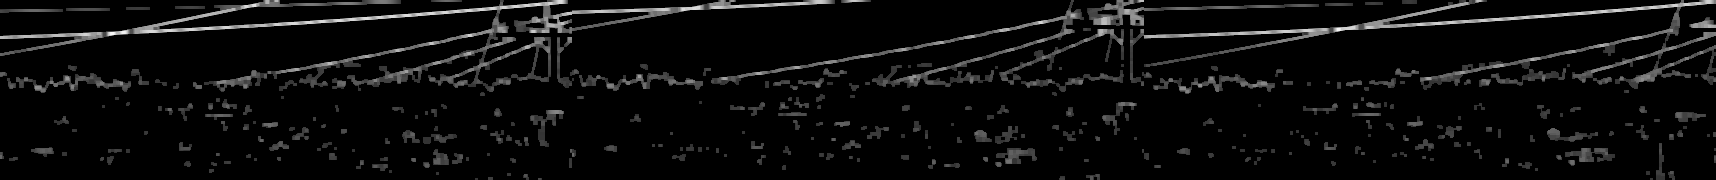

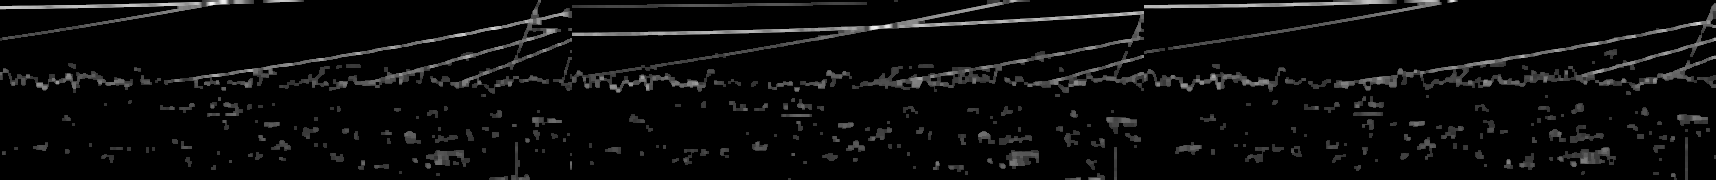

In [ ]:
wires_intensity = [calculate_intensity(w, threshold=0.2) for w in wires_gray]
imshow(np.concatenate(wires_intensity[0:3], 1))
imshow(np.concatenate(wires_intensity[3:6], 1))
imshow(np.concatenate(wires_intensity[6:9], 1))

# 3. Wybór obrazu bazowego

W kolejnym kroku należy wybrać obraz, który posłuży jako punkt wyjścia do rekonstrukcji krajobrazu.

W tym celu obliczono **średnią jasność** pikseli dla każdego zdjęcia w skali szarości.  
Następnie wybrano obraz o **największej** średniej jasności, czyli ten, który jest najbardziej jasny.

Wybór jaśniejszego zdjęcia jest uzasadniony faktem, że czarne kable znacząco obniżają lokalną jasność obrazu.  
Dlatego zdjęcie o najwyższej średniej jasności ma największe szanse być najczystsze, bez przesłonięć kablami i słupami.


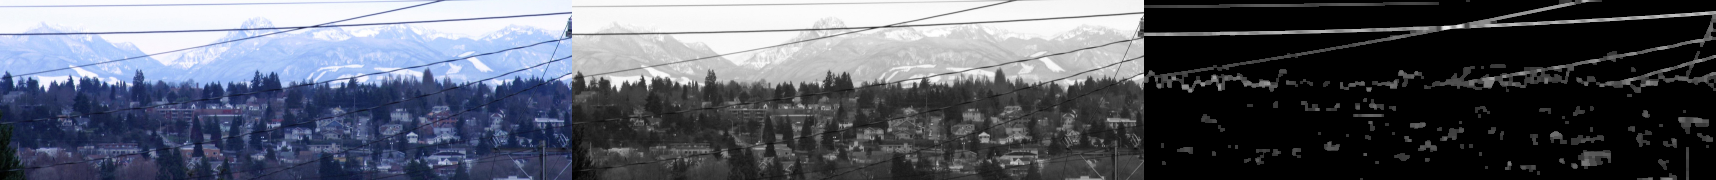

In [ ]:
sumsq = [np.mean(w) for w in wires_gray]
idx_best = np.argmax(sumsq)

img_best = wires[idx_best]
gray_best = wires_gray[idx_best]
intensity_best = wires_intensity[idx_best]

imshow(np.concatenate([
    img_best,
    cv2.cvtColor((gray_best).astype(np.uint8), cv2.COLOR_GRAY2BGR),
    cv2.cvtColor((intensity_best).astype(np.uint8), cv2.COLOR_GRAY2BGR)
], 1))

## Wizualizacja, gdzie na zdjęciu znajdują się kable

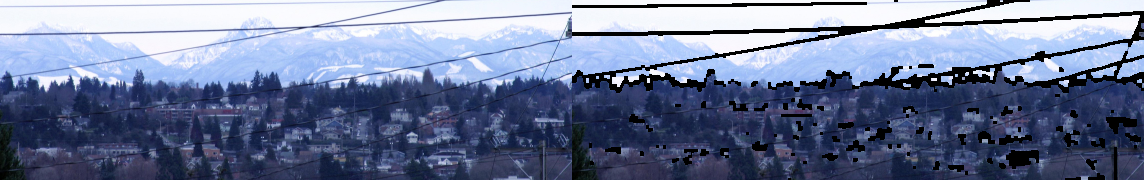

In [ ]:
mask_zeros = (intensity_best == 0).astype(np.uint8)
masked_img = img_best.copy()
masked_img[mask_zeros == 0] = 0

imshow(np.concatenate([
    img_best,
    masked_img
], 1))


Użyty filtr z dużą dokładnością wykrył miejsca, gdzie znajdują się potencjalne przeszkody w postaci kabli zasłaniających krajobraz.

# 4. Uzupełnienie zasłoniętych fragmentów

Aby **uzupełnić** obszary obrazu, które zostały zasłonięte przez kable lub inne przeszkody przygotowano trzy warianty:

- Użycie wartości **medianowych** z wielu zdjęć.
- Użycie wartości **minimalnych** (najciemniejszych) z wielu zdjęć.
- Użycie wartości **maksymalnych** (najjaśniejszych) z wielu zdjęć.

Dla każdego wariantu zachowano oryginalne piksele tam, gdzie obraz był czysty, a w miejscach przesłoniętych podstawiono odpowiednią wartość (medianę, minimum lub maksimum).


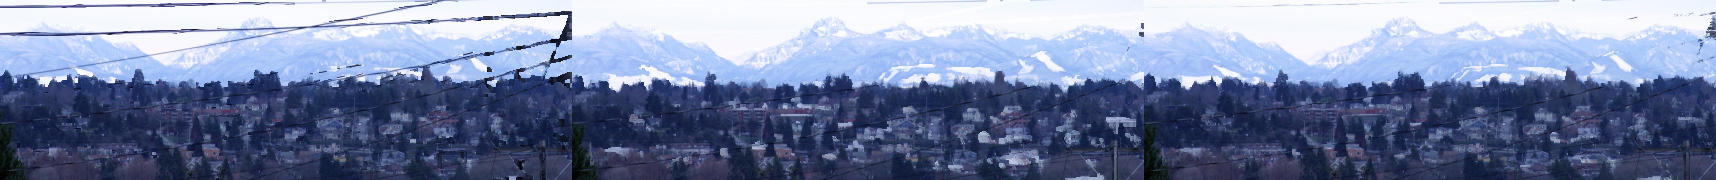

In [ ]:
mask_high = (intensity_best > 0)

wires_stack = np.stack(wires, axis=0)

min_wires_img = np.min(wires_stack, axis=0)
max_wires_img = np.max(wires_stack, axis=0)
median_wires_img = np.median(wires_stack, axis=0)

filled_img_median = img_best.copy()
filled_img_min = img_best.copy()
filled_img_max = img_best.copy()

for c in range(3):
    filled_img_median[..., c][mask_high] = median_wires_img[..., c][mask_high]
    filled_img_min[..., c][mask_high] = min_wires_img[..., c][mask_high]
    filled_img_max[..., c][mask_high] = max_wires_img[..., c][mask_high]

imshow(np.concatenate([
    filled_img_min.astype(np.uint8),
    filled_img_max.astype(np.uint8),
    filled_img_median.astype(np.uint8)
], 1))

Okazuje się że każde z powyższych podejść ma swoje wady:

- Dla wartości **minimalnych** ciemne elementy nie są w ogóle usuwane co często prowadzi nawet do pogorszenia jakości zdjęcia
- Korzystanie wyłącznie z wartości  **maksymalnych** prowadzi do nadmiernego rozmycia obrazu — szczegóły często zostają utracone.
- W przypadku podejścia **medianowego** zasłonięte elementy nie zawsze są w pełni usuwane, zwłaszcza gdy przesłaniały one dany piksel w dużej liczbie zdjęć.

Można jednak zauważyć, że są obszary, w których dana technika rardzi sobie zdecydowanie lepiej niż pozostałe. Choć żadne pojedyncze podejście nie jest idealne, to aby zwiększyć jakość przetworzonego zdjęcia należy połączyć je wszystkie ze sobą wykorzystując najlepsze cechy każdego z nich.

# 5. Łączenie wyników z różnych podejść

W poniższym algorytmie zaproponowano strategię łączenia segmentowego:

## 5.1 Podział obrazu na mniejsze segmenty

Pełny obraz został podzielony na **40 segmentów** — **10 kolumn** i **4 wiersze**.  
Każdy segment to prostokątny fragment obrazu o wymiarach dopasowanych do całkowitej szerokości i wysokości.

Segmentacja pozwala analizować obraz lokalnie i dostosować wybór najlepszego podejścia do konkretnego obszaru.

## 5.2 Ocena jakości dla każdego podejścia

Dla każdego podejścia obliczono **intensywność** przesłonięcia (na podstawie wartości jasności) oraz wyznaczono **stopień intensywności**, sumując kwadraty wartości w segmencie.

Niższy wynik oznacza lepsze dopasowanie — mniejszą ilość zakłóceń i przesłonięć.

## 5.3 Wybór najlepszego wariantu dla każdego segmentu

Dla każdego segmentu wybrano podejście, które miało **najniższy stopień intensywności**.  
W wyniku tego procesu:

- Czyste obszary są wybierane na podstawie najlepszego wariantu.
- Zminimalizowano wpływ przesłonięć.
- Wzmocniono szczegóły i ograniczono rozmycie tam, gdzie to było możliwe.


In [ ]:
mask_high = (intensity_best > 0) * 255
h, w = img_best.shape[:2]
n_cols = 10
n_rows = 4
segment_width = w // n_cols
segment_height = h // n_rows

intensity_min = calculate_intensity(min_wires_img, threshold=0.2)
intensity_max = calculate_intensity(max_wires_img, threshold=0.2)
intensity_median = calculate_intensity(median_wires_img, threshold=0.2)

segments_img = []
segments_mask = []

for i in range(n_rows):
    for j in range(n_cols):
        y_start = i * segment_height
        y_end = (i + 1) * segment_height if i < n_rows - 1 else h
        x_start = j * segment_width
        x_end = (j + 1) * segment_width if j < n_cols - 1 else w

        img_segment_min = filled_img_min[y_start:y_end, x_start:x_end]
        img_segment_max = filled_img_max[y_start:y_end, x_start:x_end]
        img_segment_median = filled_img_median[y_start:y_end, x_start:x_end]

        mask_segment = mask_high[y_start:y_end, x_start:x_end]

        seg_intensity_min = intensity_min[y_start:y_end, x_start:x_end]
        seg_intensity_max = intensity_max[y_start:y_end, x_start:x_end]
        seg_intensity_median = intensity_median[y_start:y_end, x_start:x_end]

        score_min = np.sum(seg_intensity_min ** 2)
        score_max = np.sum(seg_intensity_max ** 2)
        score_median = np.sum(seg_intensity_median ** 2)

        scores = [score_min, score_max, score_median]
        img_segments = [img_segment_min, img_segment_max, img_segment_median]
        best_idx = np.argmin(scores)

        segments_img.append(img_segments[best_idx])
        segments_mask.append(mask_segment)


## 5.4 Łączenie najlepszych segmentów z powrotem

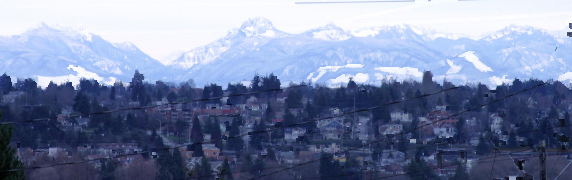

In [ ]:
def concatenate_segments(segments_img, segments_mask, n_rows, n_cols):
    rows_img = []
    rows_mask = []

    for i in range(n_rows):
        row_img = []
        row_mask = []
        for j in range(n_cols):
            idx = i * n_cols + j
            if idx < len(segments_img):
                row_img.append(segments_img[idx])
                row_mask.append(segments_mask[idx])

        rows_img.append(np.concatenate(row_img, axis=1))
        rows_mask.append(np.concatenate(row_mask, axis=1))

    final_img = np.concatenate(rows_img, axis=0)
    final_mask = np.concatenate(rows_mask, axis=0)

    return final_img

final_img = concatenate_segments(segments_img, segments_mask, n_rows, n_cols)
imshow(final_img)

# 6. Porównanie wyników


===
Wynik usyskany przez badaczy



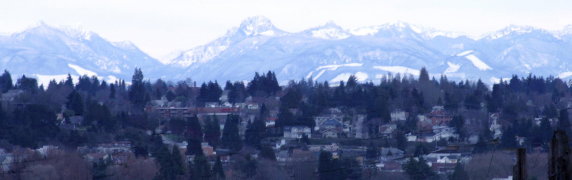


===
Wynik algorytmu



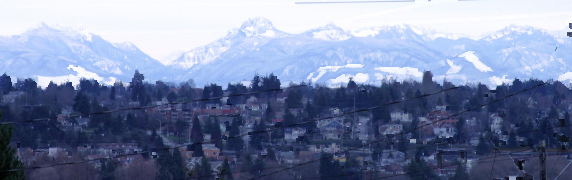

In [ ]:
result = cv2.imread('./wire/res.png', 1)
result = cv2.resize(result, None, fx=0.5, fy=0.5)

print('\n===')
print('Wynik usyskany przez badaczy\n')
imshow(result)
print('\n===')
print('Wynik algorytmu\n')
imshow(final_img)

# 7. Wnioski

Opracowana metoda umożliwiła skuteczne usunięcie obiektów przesłaniających niebo, takich jak słupy oraz większość kabli.  
W dalszym ciągu widoczne są jednak szczątkowe fragmenty kabli przesłaniających łąkę, zwłaszcza w dolnej części obrazu.

Warto podkreślić, że zdjęcie wynikowe, do którego się porównujemy, zostało wykonane z użyciem specjalistycznego oprogramowania oraz ingerencji ludzkiej — ręcznie wskazano na nim pozycje kabli do usunięcia.  
W związku z tym efekt porównawczy był trudny do osiągnięcia przy pełnej automatyzacji procesu.

Należy również zauważyć, że zadanie usunięcia przesłaniających obiektów mogłoby zostać wykonane znacznie lepiej przy użyciu bardziej zaawansowanych technik:

- **Transformata Hougha** pozwala na skuteczne wykrywanie długich, prostych linii, co idealnie pasuje do problemu identyfikacji kabli.
- **Sieci neuronowe** specjalnie trenowane do segmentacji obrazu mogłyby automatycznie rozpoznać i usunąć niechciane elementy.

Niestety, ze względu na ograniczenia projektu, wykorzystanie tych narzędzi nie było możliwe w tym zadaniu.
